# 本节内容摘要


线性回归

- 线性模型

- 衡量估计质量

- 训练数据

- 参数学习

  > 训练损失  
  > 最小化损失来学习参数

- 显示解

  > 线性回归有显示解，即可以直接矩阵数学运算，得到参数w和b的最优解，而不是用梯度下降，牛顿法等参数优化方式一点点逼近最优解。  
  > **推导过程**

- 总结

  > 线性回归是对n维输入的加权，外加偏差  
  > 使用**平方损失**来衡量预测值和真实值之间的误差  
  > **线性回归有显示解**  
  > 线性回归可以看作单层神经网络  




# 讲义

In [1]:
from IPython.display import display, IFrame

# 使用IFrame将PDF文件嵌入到Notebook中
pdf_path = "../PPT/part-0_8.pdf"
display(IFrame(pdf_path, width=1100, height=600))


# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 2.6529, -0.4641]) 
label: tensor([11.0803])


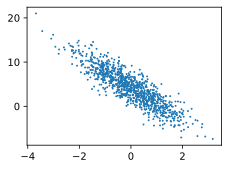

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [6]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)  # 样本个数
    indices = list(range(num_examples)) # 样本索引
    # 这些样本是随即读取的，没有特定的顺序
    random.shuffle(indices) # 把索引随即打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)]) # 当i+batch_size超出时，取num_examples         
        yield features[batch_indices], labels[batch_indices] # 获得随即顺序的特征，及对应的标签
        
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 取一个批次后，就break跳出了
    break

tensor([[ 0.6669, -0.3959],
        [ 1.5478,  1.8241],
        [ 0.3094,  0.0258],
        [ 1.0205, -1.3970],
        [-0.1640, -0.1846],
        [-0.7335,  0.7464],
        [-1.7659, -0.5073],
        [ 2.0104,  0.1336],
        [ 0.0445, -0.2605],
        [-0.1978, -0.7967]]) 
 tensor([[ 6.8790],
        [ 1.0951],
        [ 4.7401],
        [10.9862],
        [ 4.4956],
        [ 0.2020],
        [ 2.3961],
        [ 7.7690],
        [ 5.1783],
        [ 6.5122]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [8]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [9]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [10]:
def sgd(params,lr,batch_size):
    """小批量随即梯度下降"""
    with torch.no_grad(): # 不要产生梯度计算，减少内存消耗
        for param in params: # 每个参数进行遍历
            param -= lr * param.grad / batch_size # 每个参数进行更新，损失函数没有求均值，所以这里除以 batch_size 求了均值。由于乘法的线性关系，这里除以放在loss的除以是等价的。                          
            param.grad.zero_() # 每个参数的梯度清零

训练过程

In [11]:
lr = 0.03
num_epochs = 3
net = linreg # 这里用线性模型，这样写是很方便net赋予其他模型，只需要改一处，不需要下面所有网络模型名称都改
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # x和y的小批量损失
        # 因为l是形状是(batch_size,1)，而不是一个标量。l中所有元素被加到一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')   

epoch1,loss0.027098
epoch2,loss0.000103
epoch3,loss0.000051


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [12]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([-3.4118e-04,  6.1989e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0003], grad_fn=<RsubBackward1>)
